In [ ]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 100
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 30
AUGMENT_BRIGHTNESS = False

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '/content/drive/MyDrive/Colab_Notebooks/Test_task/Data'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')
import gc; gc.enable() # memory is tight

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)
  

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    channel = 0 ## alternate through color channels
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += np.log1p(i+1) * rle_decode(mask)
    return all_masks

In [ ]:
masks = pd.read_csv(os.path.join('/content/drive/MyDrive/Colab_Notebooks/Test_task/Data',
                                 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


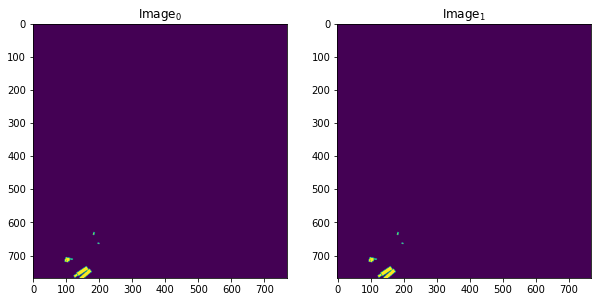

In [ ]:
#Make sure encode/decode works
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
95901,7f87715ac.jpg,0,0.0,[0.0],197.215820
142137,bcf1a731a.jpg,0,0.0,[0.0],124.457031
57937,4d3f86759.jpg,0,0.0,[0.0],119.079102
27921,2520ace9a.jpg,0,0.0,[0.0],215.485352
5762,07b27f307.jpg,0,0.0,[0.0],154.524414


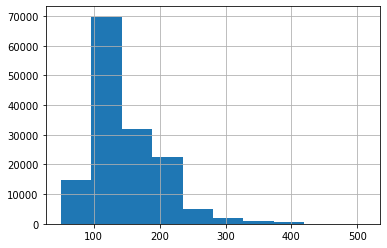

In [ ]:
#Split into training and validation groups
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
drop_index = []
for index, row in unique_img_ids.iterrows():
  try:
    unique_img_ids.loc[index, 'file_size_kb'] = os.stat(os.path.join(train_image_dir, row['ImageId'])).st_size/1024
  except:
    drop_index.append(index)
unique_img_ids.drop(drop_index)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [ ]:
unique_img_ids.to_csv("/content/drive/MyDrive/Colab_Notebooks/Test_task/unique_img_ids.csv")

In [ ]:
unique_img_ids = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Test_task/unique_img_ids.csv")

In [ ]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

124405 training masks
53324 validation masks


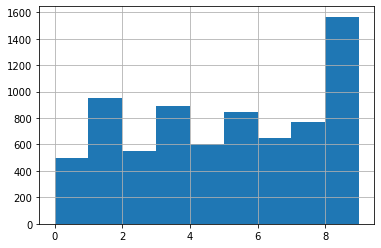

In [ ]:
#Undersample Empty Images
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3)
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
    
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))

In [ ]:
#Decode all the RLEs into Images
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            try:
              c_img = imread(rgb_path)
            except:
              continue
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield (np.stack(out_rgb, 0)/255.0).astype('float32'), np.stack(out_mask, 0).astype('float32')
                out_rgb, out_mask=[], []

In [ ]:
train_gen = make_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

In [ ]:
#Make the Validation Set
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

In [ ]:
#Augment Data
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

In [ ]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [ ]:
gc.collect()

In [ ]:
from keras import models, layers
from tensorflow.keras import regularizers
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)
d1 = layers.Dropout(0.15)(p1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (d1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)
d2 = layers.Dropout(0.15)(p2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (d2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)
d3 = layers.Dropout(0.15)(p3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (d3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)
d4 = layers.Dropout(0.15)(p4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (d4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)
d6 = layers.Dropout(0.15)(c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (d6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)
d7 = layers.Dropout(0.15)(c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (d7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)
d8 = layers.Dropout(0.15)(c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (d8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)
d9 = layers.Dropout(0.1)(c9)
#kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
d = layers.Conv2D(1, (1, 1), activation='sigmoid') (d9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

In [ ]:
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)


def gdice_coef(y_true, y_pred):
    #y_true_f = K.flatten(y_true)
    #y_pred_f = K.flatten(y_pred)
    A = K.sum(y_true, axis=[1,2,3])
    B = K.sum(y_pred, axis=[1,2,3])
    
    TP = K.sum(y_true * y_pred, axis=[1,2,3])
    two_TP = 2. * TP
    
    FN = A - TP
    FP = B - TP
    FP_1 = FP + (K.square(FP) / ( TP + FN + K.epsilon() ))
    
    G_DICE = (two_TP + K.epsilon()) / (two_TP + FN + FP_1 + K.epsilon())
    return (G_DICE)

def gdice_coef_loss(y_true, y_pred):
    return -gdice_coef(y_true, y_pred)

def sgdice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    A = K.sum(y_true_f, axis=[1,2,3])
    B = K.sum(y_pred_f, axis=[1,2,3])
    
    TP = K.sum(y_true_f * y_pred_f, axis=[1,2,3])
    two_TP = 2. * TP
    
    FN = A - TP
    FP = B - TP
    FP_1 = FP + (K.square(FP) / ( TP + FN - FP + K.epsilon() ))
    
    SG_DICE = (two_TP + K.epsilon()) / (two_TP + FN + FP_1 + K.epsilon())
    return (SG_DICE)

def sgdice_coef_loss(y_true, y_pred):
    return -sgdice_coef(y_true, y_pred)





seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=gdice_coef_loss, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.1, 
                                   patience=3, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [seg_model.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=10, 
                             validation_data=(valid_x, valid_y),
                             callbacks=callbacks_list,
                            workers=1
                                       )]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.0159 - dice_coef: 0.0050 - binary_accuracy: 0.9635 - true_positive_rate: 0.0382
Epoch 1: val_dice_coef improved from -inf to 0.82720, saving model to seg_model_weights.best.hdf5
400/400 [==============================] - 312s 777ms/step - loss: 0.0159 - dice_coef: 0.0050 - binary_accuracy: 0.9635 - true_positive_rate: 0.0382 - val_loss: -0.2743 - val_dice_coef: 0.8272 - val_binary_accuracy: 0.9987 - val_true_positive_rate: nan - lr: 1.0000e-04
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 8.8353e-04 - dice_coef: 0.0058 - binary_accuracy: 0.7082 - true_positive_rate: 0.3035
Epoch 2: val_dice_coef did not improve from 0.82720
400/400 [==============================] - 312s 782ms/step - loss: 8.8353e-04 - dice_coef: 0.0058 - binary_accuracy: 0.7082 - true_positive_rate: 0.3035 - val_loss: 0.0012 - val_dice_coef: 0.0024 - val_binary_accuracy: 0.5982 - val_true_positive_rate: nan - lr: 1.0000e-04

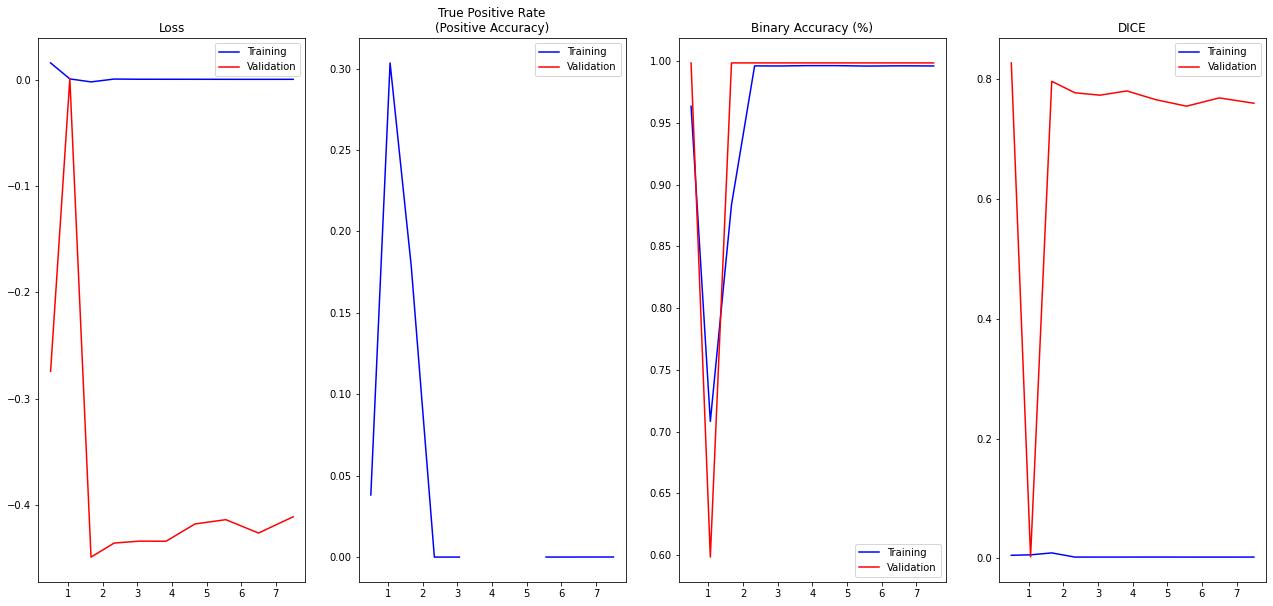

In [ ]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [ ]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

In [ ]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

(100, 768, 768, 1) 0.0 9.062117e-05 2.21073e-09


In [ ]:
#Prepare Full Resolution Model
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save('fullres_model.h5')

In [ ]:
fullres_model.load_weights('fullres_model.h5')

In [ ]:
fullres_model.save("model")

In [ ]:
test_paths = os.listdir("/content/drive/MyDrive/Colab_Notebooks/Test_task/Data/test_v2")
print(len(test_paths), 'test images found')

15606 test images found


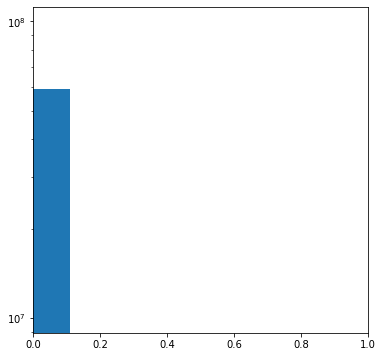

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


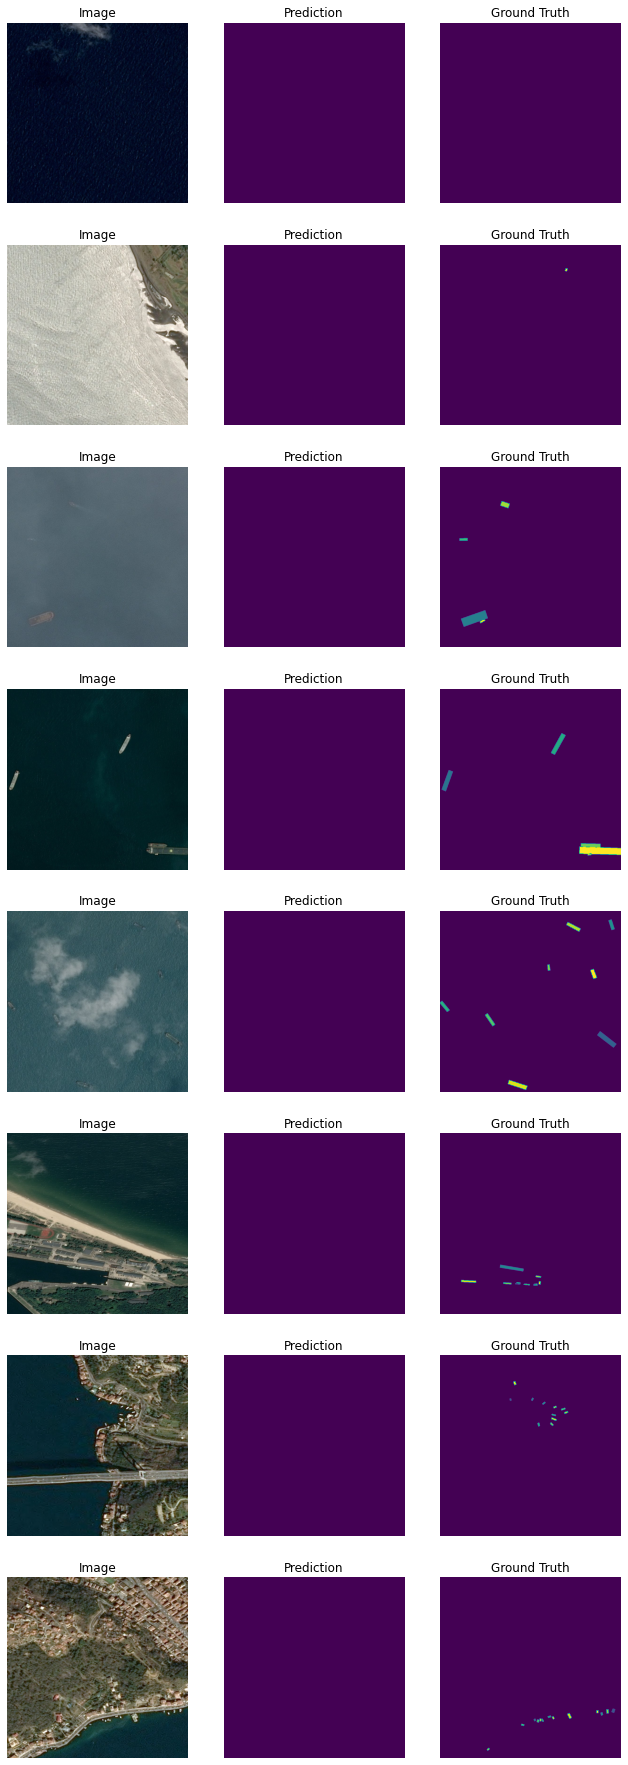

In [ ]:
def predict(img, path=test_image_dir):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg = binary_opening(cur_seg>1e3, np.expand_dims(disk(2), -1))
    return cur_seg, c_img

def pred_encode(img):
    cur_seg, _ = predict(img)
    cur_rles = rle_encode(cur_seg)
    return [img, cur_rles if len(cur_rles) > 0 else None]

## Get a sample of each group of ship count
samples = train_df.groupby('grouped_ship_count').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 3, figsize = (11, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = predict(c_img_name, train_image_dir)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[:, :, 0])
    ax2.set_title('Prediction')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax3.imshow(ground_truth)
    ax3.set_title('Ground Truth')
    
fig.savefig('predictions.png')

In [ ]:
%%time
from tqdm import tqdm_notebook

out_pred_rows = []
for c_img_name in tqdm_notebook(test_paths[:30000]): ## only a subset as it takes too long to run
    out_pred_rows += [pred_encode(c_img_name)]

In [ ]:
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
sub = sub[sub.EncodedPixels.notnull()]
sub.head()

,ImageId,EncodedPixels


In [ ]:
sub1 = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Test_task/Data/sample_submission_v2.csv')
sub1 = pd.DataFrame(np.setdiff1d(sub1['ImageId'].unique(), sub['ImageId'].unique(), assume_unique=True), columns=['ImageId'])
sub1['EncodedPixels'] = None
print(len(sub1), len(sub))

sub = pd.concat([sub, sub1])
print(len(sub))
sub.to_csv('submission.csv', index=False)
sub.head()

15606 0
15606


,ImageId,EncodedPixels
0,00002bd58.jpg,None
1,00015efb6.jpg,None
2,00023d5fc.jpg,None
3,000367c13.jpg,None
4,0008ca6e9.jpg,None
